In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.metrics
import seaborn as sns

from approaches import baseline, cluster_methods, oracle
from approaches_ftc import ftc
from approaches_agenda import agenda

In [20]:
legend_fontsize = 14
title_fontsize = 18
label_fontsize = 16
ticks_fontsize = 14

In [36]:
db = pd.read_csv('data/rfw/rfw_w_sims.csv')
dataset_name = 'rfw'
feature = 'facenet'
calibration_method = 'beta'
nbins = 25
n_clusters = 100

In [37]:
subgroups = {'ethnicity': ['African', 'Asian', 'Caucasian', 'Indian']}
sensitive_attributes = {'ethnicity': ['ethnicity', 'ethnicity']}
fold = 5

In [38]:
features = ['facenet-webface']

In [39]:
title_features = {
    'facenet':'FaceNet (VGGFace2)',
    'facenet-webface':'FaceNet (Webface)',
    'arcface': 'ArcFace'}

In [40]:
title_methods = {
    'naive': 'Baseline',
    'fsn': 'FSN [36]',
    'bmc': 'BMC (Ours)',
    'oracle': 'Oracle'
}

In [41]:
db_fold = {'cal': db[db['fold'] != fold], 'test': db[db['fold'] == fold]}

In [42]:
scores = {}
confidences = {}
for feature in features:
    scores[feature] = {}
    confidences[feature] = {}
ground_truth = {}
subgroup_scores = {}
for dataset in ['cal', 'test']:
    for feature in features:
        scores[feature][dataset] = np.array(db_fold[dataset][feature])
    ground_truth[dataset] = np.array(db_fold[dataset]['same'])
    subgroup_scores[dataset] = {}
    for att in subgroups.keys():
        subgroup_scores[dataset][att] = {}
        subgroup_scores[dataset][att]['left'] = np.array(db_fold[dataset][sensitive_attributes[att][0]])
        subgroup_scores[dataset][att]['right'] = np.array(db_fold[dataset][sensitive_attributes[att][1]])


In [43]:
[feature]


['facenet-webface']

In [44]:
for feature in features:
    confidences[feature]['baseline'] = baseline(scores[feature], ground_truth, nbins, calibration_method)
    confidences[feature]['oracle'] = oracle(scores[feature], ground_truth, subgroup_scores, subgroups, nbins, calibration_method)

ValueError: Input X contains NaN.
LogisticRegression does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [45]:
for feature in features:
    _, _, confidences[feature]['bmc'], cluster_settings = cluster_methods(
                nbins,
                calibration_method,
                dataset_name,
                feature,
                fold,
                db_fold,
                100,
                False,
                0
            )

TypeError: cluster_methods() missing 1 required positional argument: 'embedding_data'

In [46]:
for feature in features:
    _, _, confidences[feature]['fsn'], cluster_settings = cluster_methods(
                nbins,
                calibration_method,
                dataset_name,
                feature,
                fold,
                db_fold,
                100,
                True,
                1e-3
            )

TypeError: cluster_methods() missing 1 required positional argument: 'embedding_data'

In [47]:
for feature in features:
    _, confidences[feature]['ftc'], _ = ftc(dataset_name, feature, db_fold, nbins, calibration_method)

FileNotFoundError: [Errno 2] No such file or directory: 'data/rfw/African_facenet-webface_embeddings.pickle'

In [13]:
for feature in features:
    _, confidences[feature]['agenda'], _, _, _ = agenda(dataset_name, feature, db_fold, nbins, calibration_method)

TypeError: agenda() missing 1 required positional argument: 'embedding_data'

In [14]:
db_fold['test']['baseline'] = confidences['facenet-webface']['baseline']['test']
db_fold['test']['oracle'] = confidences['facenet-webface']['oracle']['test']['ethnicity']
db_fold['test']['fsn'] = confidences['facenet-webface']['fsn']['test']
db_fold['test']['ftc'] = confidences['facenet-webface']['ftc']['test']
db_fold['test']['agenda'] = confidences['facenet-webface']['agenda']['test']
db_fold['test']['bmc'] = confidences['facenet-webface']['bmc']['test']

KeyError: 'baseline'

In [15]:
legend_fontsize = 18
title_fontsize = 24
label_fontsize = 20
ticks_fontsize = 18

KeyError: 'Ungenuine'

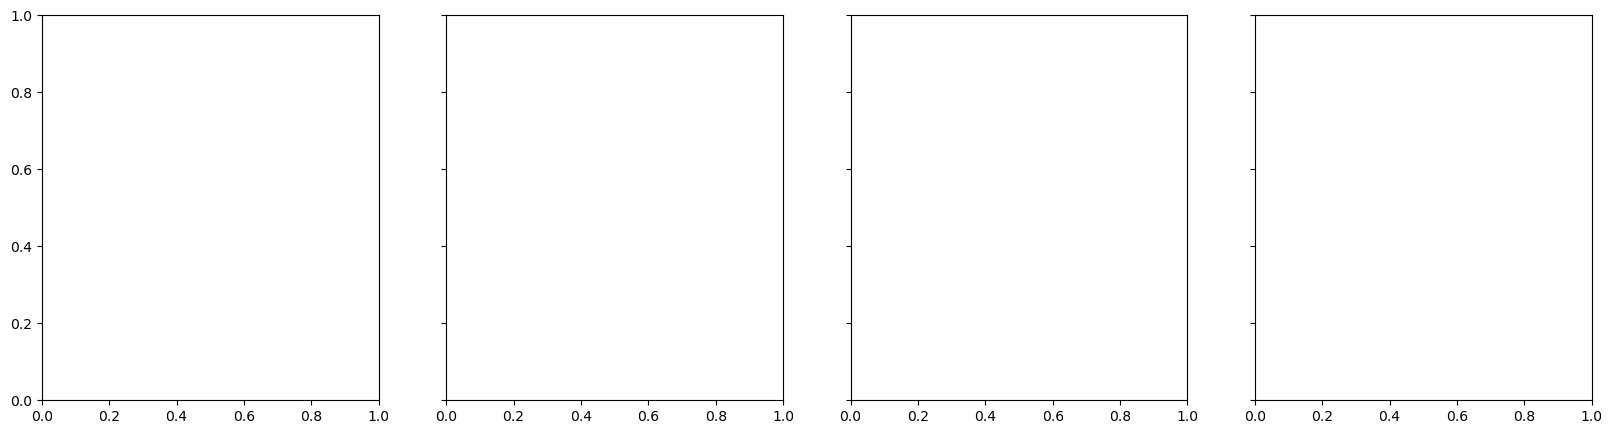

In [16]:
subgroups = ['African', 'Asian', 'Caucasian', 'Indian']
title_columns = ['Baseline', 'Baseline+Calibration', 'Oracle Calibration', 'FairCal (Ours)']
columns = ['facenet-webface','baseline','oracle', 'bmc']
fig, axes = plt.subplots(1,len(columns),figsize=(20,5), sharey=True)

# creating a dictionary with one specific color per group:
my_pal = {"Genuine": "royalblue", "Imposter": "skyblue"}
fpr_subgroup = {}
for i_aux, aux in enumerate(columns):
    sns.violinplot(
    x ='ethnicity',
    hue="pair",
    y=aux,
    split=True,
    data=db_fold['test'],
    scale="count",
    inner="quartile",
    ax = axes[i_aux],
    order=subgroups,
    palette=my_pal
)
    axes[i_aux].legend(loc = 'lower right', fontsize=legend_fontsize)
    axes[i_aux].set_xlabel('Ethnicity', fontsize=label_fontsize)
    axes[i_aux].set_title(title_columns[i_aux], fontsize=title_fontsize)
    if i_aux == 0:
        axes[i_aux].set_ylabel('Cosine Similarity Score', fontsize=label_fontsize)
    else:
        axes[i_aux].set_ylabel('Probability', fontsize=label_fontsize)
    labels = [item.get_text() for item in axes[i_aux].get_yticklabels()]
    empty_string_labels = ['']*len(labels)
    axes[i_aux].set_yticklabels(empty_string_labels)

    axes[i_aux].tick_params(axis='x', labelsize=ticks_fontsize-2)

    global_fpr,global_tpr,global_thr = sklearn.metrics.roc_curve(
            y_true = ground_truth['test'],
            y_score = db_fold['test'][aux],
            drop_intermediate=False,
            pos_label = True)
    
    axes[i_aux].axhline(global_thr[np.argmin(np.abs(global_fpr-0.05))],
                    ls='-',
                    linewidth=2,
                    alpha = 1,
                    c='black')
    fpr_subgroup[aux] = {}
    for j, subgroup in enumerate(subgroups):
        select = subgroup_scores['test']['ethnicity']['left'] == subgroup
        fpr,tpr,thr = sklearn.metrics.roc_curve(
            y_true = ground_truth['test'][select],
            y_score = db_fold['test'][aux][select],
            drop_intermediate=False,
            pos_label = True)
        axes[i_aux].hlines(y = thr[np.argmin(np.abs(fpr-0.05))],
                       ls='-',
                       color='crimson',
                       linewidth=3,
                       xmin =j-0.5,
                       xmax = j+1-0.5)
        fpr_subgroup[aux][j] = 100*fpr[np.argmin(np.abs(thr-np.interp(0.05,global_fpr,global_thr)))]
        print("%s - %s FPR = %1.3f"%(title_columns[i_aux], subgroup, fpr_subgroup[aux][j]))
fig.tight_layout()
plt.savefig('figs_iclr/facenet-webface_score_distributions_fpr_thresholds.png', bbox_inches='tight')

In [ ]:

feature = 'facenet-webface'
metrics = {'aad': {}, 'mad': {}, 'std': {}}
subgroups = ['African', 'Asian', 'Indian', 'Caucasian']
title_columns = ['Baseline', 'AGENDA','FTC', 'FSN', 'FairCal (Ours)']
columns = ['facenet-webface','agenda', 'ftc', 'fsn','bmc']
fig, axes = plt.subplots(1,len(columns),figsize=(20,5), sharey=True)
for i_aux,aux in enumerate(columns):
    global_fpr,global_tpr,global_thr = sklearn.metrics.roc_curve(
            y_true = ground_truth['test'],
            y_score = db_fold['test'][aux],
            drop_intermediate=False,
            pos_label = True)
    fpr_subgroup[aux] = np.zeros(len(subgroups))
    for j, subgroup in enumerate(subgroups):
        select = subgroup_scores['test']['ethnicity']['left'] == subgroup
        fpr,tpr,thr = sklearn.metrics.roc_curve(
            y_true = ground_truth['test'][select],
            y_score = db_fold['test'][aux][select],
            drop_intermediate=False,
            pos_label = True)
        axes[i_aux].plot(np.interp(thr,global_thr[::-1],global_fpr[::-1]),fpr, linewidth=2)
        fpr_subgroup[aux][j] = 100*fpr[np.argmin(np.abs(thr-np.interp(0.05,global_fpr,global_thr)))]
        print('%s %s - %1.1f'%(title_columns[i_aux],subgroup, fpr_subgroup[aux][j]))
    metrics['aad'][aux] = np.mean(np.abs(fpr_subgroup[aux]-np.mean(fpr_subgroup[aux])))
    metrics['mad'][aux] = np.max(np.abs(fpr_subgroup[aux]-np.mean(fpr_subgroup[aux])))
    metrics['std'][aux] = np.std(fpr_subgroup[aux])
    # print('AAD = %1.2f'%metrics['aad']['bmc'])
    # print('MAD = %1.2f'%metrics['mad']['bmc'])
    # print('STD = %1.2f'%metrics['std']['bmc'])
    axes[i_aux].plot([0.05, 0.05],[0,1],'--k',linewidth=2)
    axes[i_aux].legend(subgroups,loc = 'upper left')
    axes[i_aux].set_xticks([0,0.02,0.04,0.06,0.08,0.1])
    axes[i_aux].set_xlim(0,0.1)
    axes[i_aux].set_ylim(0,0.18)
    axes[i_aux].set_title(title_columns[i_aux], fontsize=title_fontsize)
    axes[i_aux].set_xlabel('Global FPR', fontsize=title_fontsize)
    if i_aux == 0:
        axes[i_aux].set_ylabel('False Positive Rate', fontsize=title_fontsize)
    axes[i_aux].tick_params(axis='both', which='major', labelsize=ticks_fontsize)
fig.tight_layout()
plt.savefig('figs_iclr/facenet-webface_thr_vs_fpr.png', bbox_inches='tight')